# Andrew Yang's Freedom Dividend

Estimate the effect of Andrew Yang's [Freedom Dividend](https://www.yang2020.com/policies/the-freedom-dividend/) of $12,000 per year per adult over age 18, funded by a 10 percent [value-added tax](https://www.yang2020.com/policies/value-added-tax/) and reducing benefits by up to the UBI amount for each tax unit.

Assumptions:
* Adults are 18+ not 19+, for data availability.
* Benefits include Social Security, SNAP, WIC, SSI, TANF, WIC, housing benefits, and "other benefits" included in C-TAM. It does not include Medicare, Medicaid, or veteran's benefits.
* VAT incidence is proportional to [Tax Policy Center's estimate](https://www.taxpolicycenter.org/briefing-book/who-would-bear-burden-vat) of a 5 percent VAT's effect as of 2015. These are scaled linearly to match Yang's estimate that his VAT would raise $800 billion per year.
* VAT incidence is treated as an income tax; per TPC:
>Conceptually, the tax can either raise the total price (inclusive of the sales tax) paid by consumers or reduce the amount of business revenue available to compensate workers and investors. Theory and evidence suggest that the VAT is passed along to consumers via higher prices. Either way, the decline in real household income is the same regardless of whether prices rise (holding nominal incomes constant) or whether nominal incomes fall (holding the price level constant).

*Data: CPS  |  Tax year: 2019  |  Type: Static  |  Author: Max Ghenis*

## Setup

### Imports

In [1]:
import taxcalc as tc
import taxcalc_helpers as tch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'1.0.1'

### Settings

In [3]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Show one decimal in tables.
pd.set_option('precision', 2)

## Data

In [6]:
recs = tc.Records.cps_constructor()

In [7]:
BENS = ['other_ben', 'snap_ben', 'ssi_ben', 'tanf_ben', 'wic_ben']

In [8]:
base = tch.calc_df(records=recs, year=2019, 
                   group_vars=['XTOT', 'nu18'] + BENS,
                   group_n65=True,
                   metric_vars=['aftertax_income', 'XTOT'])
tch.add_weighted_quantiles(base, 'aftertax_income')

### Calculations

In [95]:
UBI = 12000
base['bens'] = base[BENS].sum(axis=1)
base['adults'] = base.XTOT - base.nu18
base['ubi_max'] = base.adults * UBI
base['ubi'] = np.where(base.ubi_max > base.bens, base.ubi_max - base.bens, 0)

Weight.

In [96]:
base['ubi_m'] = base.ubi * base.s006 / 1e6
base['ubi_max_m'] = base.ubi_max * base.s006 / 1e6
base['bens_m'] = base.bens * base.s006 / 1e6

In [97]:
base.ubi_m.sum()

2583075.3367059343

In [98]:
base.ubi_max_m.sum()

2970909.8827199996

In [99]:
base.ubi_max_m.sum() - base.ubi_m.sum()

387834.5460140654

In [100]:
base.bens_m.sum()

461648.64029236446

### VAT

Start with equal incidence, then re-weight according to [TPC paper](https://www.taxpolicycenter.org/briefing-book/who-would-bear-burden-vat).

In [101]:
TOTAL_VAT = 800e9
VAT_INCIDENCE = pd.DataFrame({
    'income_percentile_floor': [-1, 20, 40, 60, 80, 90, 95, 99, 99.9],
    'rate': [3.9, 3.6, 3.6, 3.6, 3.4, 3.2, 2.8, 2.5, 2.5]
})
VAT_INCIDENCE.rate /= 100

In [102]:
base['afti_yang_prevat'] = base.aftertax_income + base.ubi
base['afti_yang_prevat_noneg'] = base.afti_yang_prevat.clip_lower(0)

In [103]:
base.afti_yang_prevat.median() - base.aftertax_income.median()

18312.942421341926

In [104]:
tch.add_weighted_quantiles(base, 'afti_yang_prevat_noneg')

In [105]:
base['vat_rate_prescale'] = VAT_INCIDENCE.rate[
    pd.cut(base.afti_yang_prevat_noneg_percentile_exact,
           bins=VAT_INCIDENCE.income_percentile_floor.tolist() + [100],
           labels=False)].values

In [106]:
base['vat_base'] = base.afti_yang_prevat_noneg * base.vat_rate_prescale

In [111]:
vat_mult = TOTAL_VAT / tch.weighted_sum(base, 'vat_base')
vat_mult

1.5898868114189384

In [144]:
base['vat'] = base.vat_base * vat_mult
base['vat_m'] = tch.weight(base, 'vat') / 1e6
base['afti_yang_prevat_noneg_m'] = tch.weight(base, 'afti_yang_prevat_noneg_m') / 1e6

In [113]:
base['afti_yang'] = base.afti_yang_prevat - base.vat

In [114]:
tch.gini(base.aftertax_income, base.s006)

0.45102436073606283

In [116]:
tch.gini(base.afti_yang, base.s006)

0.4014956211805211

In [117]:
base.afti_yang.describe()

count    4.56e+05
mean     1.46e+05
std      1.54e+06
min     -3.11e+06
25%      5.05e+04
50%      9.62e+04
75%      1.77e+05
max      1.03e+09
Name: afti_yang, dtype: float64

In [129]:
base['afti_chg'] = base.afti_yang - base.aftertax_income
base['afti_chg_m'] = base.afti_chg * base.s006 / 1e6

In [128]:
'${} billion shortfall'.format((base.afti_chg_m.sum() / 1e6).round(2))

'$1.78 billion shortfall'

## Analysis

In [120]:
# base.sort_values('afti).head()

In [130]:
base.sort_values('afti_chg', ascending=False).head()

,wic_ben,ssi_ben,aftertax_income,snap_ben,tanf_ben,XTOT,nu18,other_ben,s006,n65,...,afti_yang_prevat_noneg_percentile_exact,afti_yang_prevat_noneg_percentile,afti_yang_prevat_noneg_2percentile,afti_yang_prevat_noneg_ventile,afti_yang_prevat_noneg_decile,afti_yang_prevat_noneg_quintile,afti_yang_prevat_noneg_quartile,afti_yang_prevat_noneg_percentile_map,vat_rate_prescale,vat_base
RECID,,,,,,,,,,,,,,,,,,,,,
167613,0.0,0.0,2935.90,0.0,0.0,12.0,0.0,0.0,877.33,0.0,...,85.87,86,86,90,9,5,4,3.4,0.03,4995.82
388397,0.0,0.0,0.00,0.0,0.0,7.0,0.0,0.0,550.97,0.0,...,61.44,62,62,65,7,4,3,3.6,0.04,3024.00
201238,0.0,0.0,20623.71,0.0,0.0,7.0,0.0,0.0,107.18,0.0,...,72.43,73,74,75,8,4,3,3.6,0.04,3766.45
201242,0.0,0.0,20623.71,0.0,0.0,7.0,0.0,0.0,107.18,0.0,...,72.43,73,74,75,8,4,3,3.6,0.04,3766.45
201244,0.0,0.0,20623.71,0.0,0.0,7.0,0.0,0.0,107.18,0.0,...,72.43,73,74,75,8,4,3,3.6,0.04,3766.45


In [145]:
decile = base.groupby('aftertax_income_decile')['aftertax_income_m', 'afti_chg_m',
                                                'vat_m', 'afti_yang_prevat_noneg_m', 's006'].sum()
decile['afti_chg'] = 1e6 * decile.afti_chg_m / decile.s006
decile['afti_chg_pct'] = decile.afti_chg_m / decile.aftertax_income_m
decile['vat'] = 1e6 * decile.vat_m / decile.s006
decile['vat_pct'] = decile.vat_m / decile.afti_yang_prevat_noneg_m
decile.drop(0, inplace=True)
decile

,aftertax_income_m,afti_chg_m,vat_m,afti_yang_prevat_noneg_m,s006,afti_chg,afti_chg_pct,vat,vat_pct
aftertax_income_decile,,,,,,,,,
1,1.65e+05,172599.07,22195.81,18.21,1.65e+07,10475.35,1.05,1347.10,1218.91
2,3.87e+05,172044.26,36242.02,38.49,1.65e+07,10410.32,0.45,2192.99,941.61
3,5.18e+05,165985.66,42080.28,43.87,1.65e+07,10044.04,0.32,2546.34,959.18
4,6.45e+05,166226.71,49304.50,52.02,1.65e+07,10058.11,0.26,2983.34,947.79
5,7.93e+05,170713.30,58476.96,59.14,1.65e+07,10330.07,0.22,3538.51,988.74
6,9.76e+05,175716.06,69921.06,66.97,1.65e+07,10631.49,0.18,4230.49,1044.06
7,1.21e+06,186236.91,84499.54,81.17,1.65e+07,11269.41,0.15,5113.16,1041.02
8,1.52e+06,198841.83,103539.30,92.94,1.65e+07,12031.61,0.13,6265.00,1114.07
9,2.03e+06,207124.10,128374.27,107.68,1.65e+07,12532.87,0.10,7767.79,1192.22


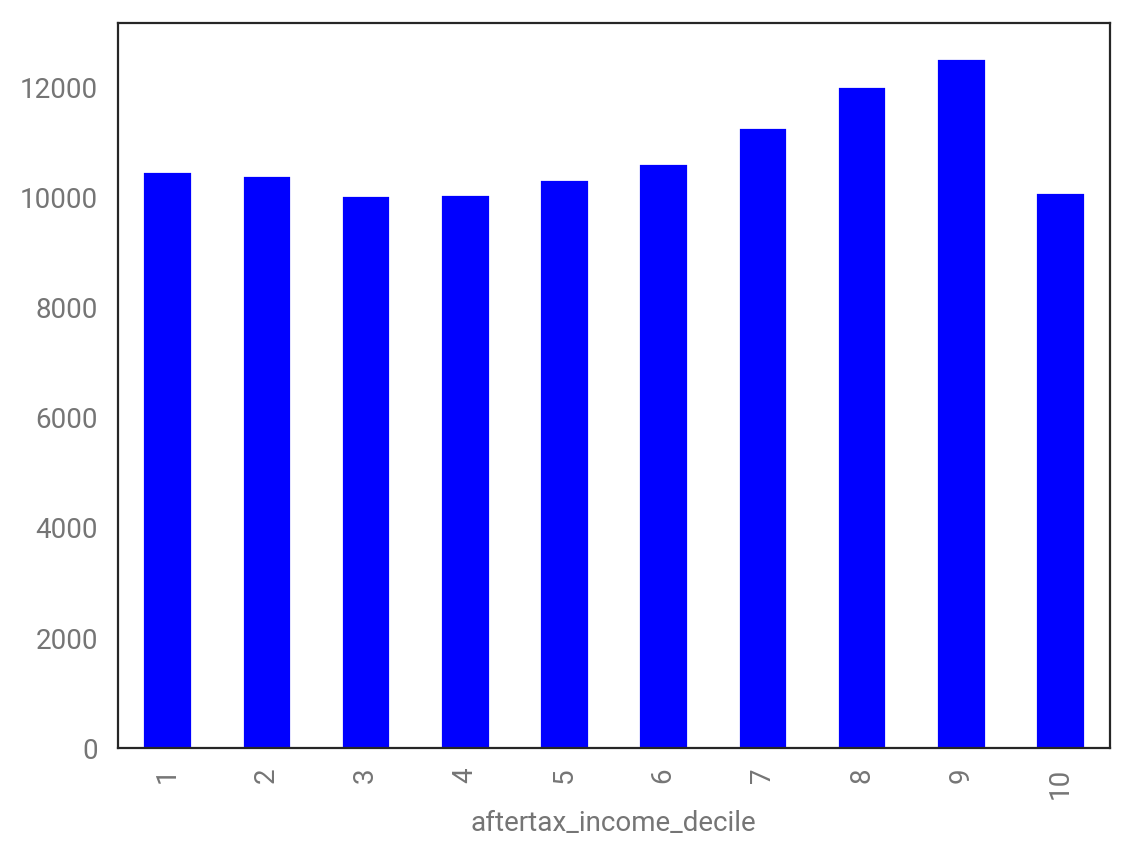

In [146]:
decile.afti_chg.plot('bar', color='blue')
plt.show()

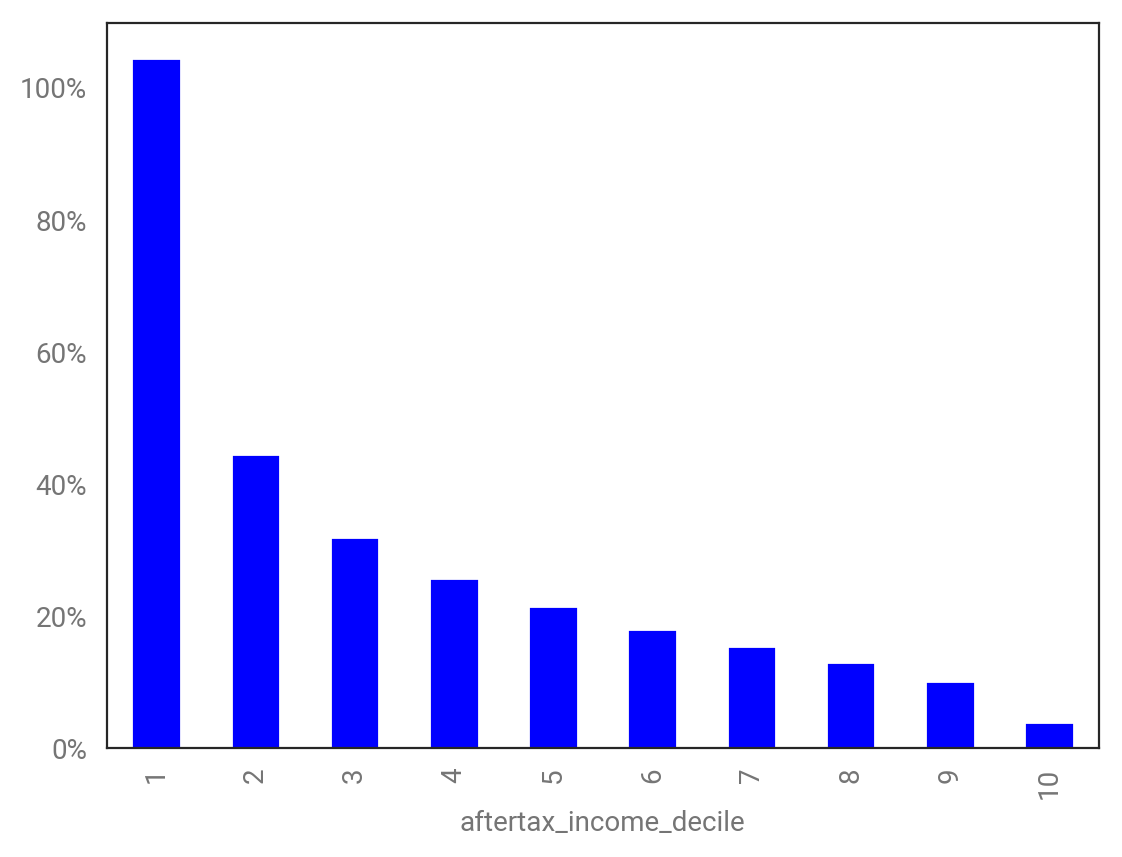

In [147]:
ax = decile.afti_chg_pct.plot('bar', color='blue')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, _: '{:.0%}'.format(y)))
plt.show()

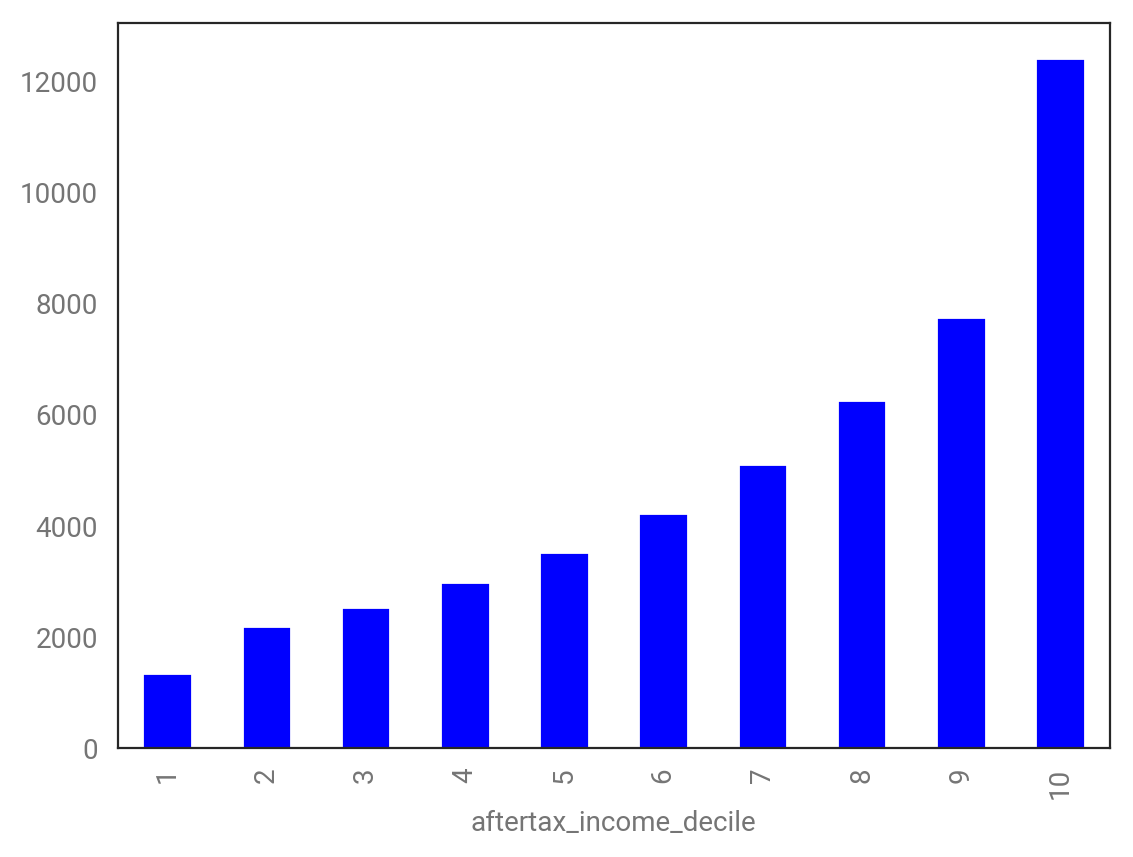

In [148]:
decile.vat.plot('bar', color='blue')
plt.show()

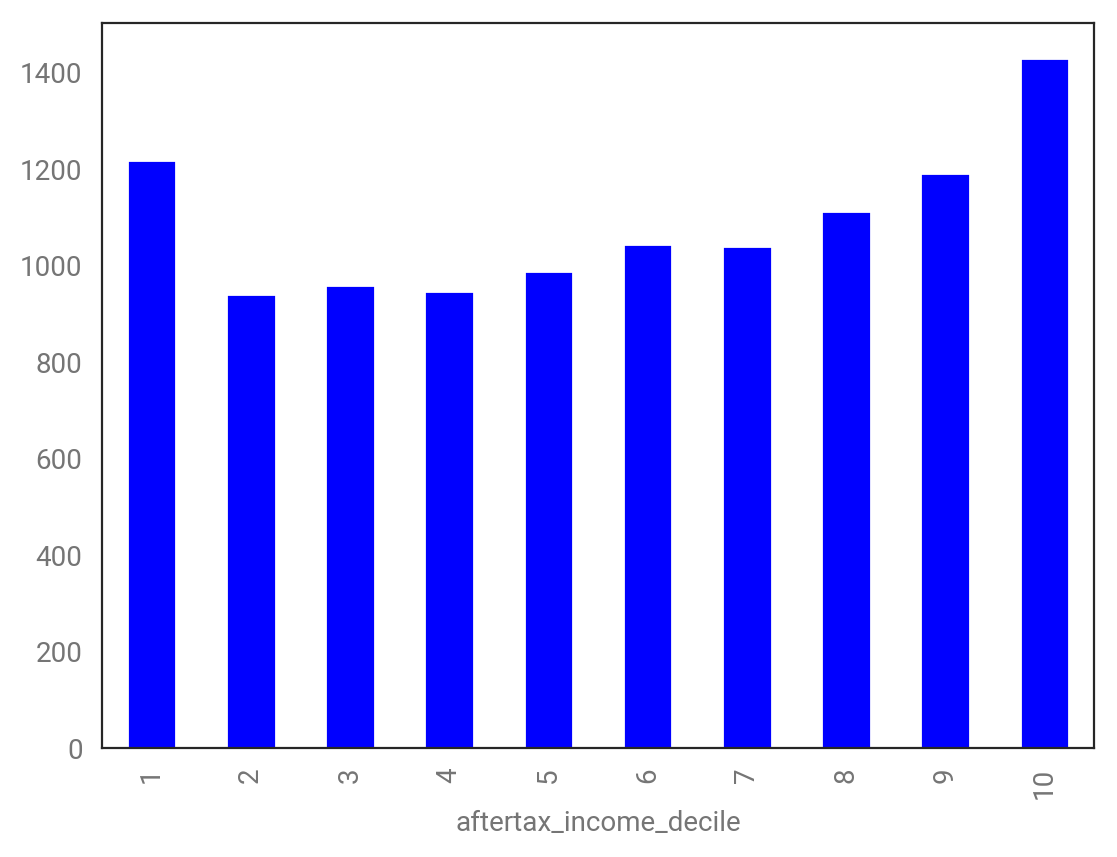

In [149]:
decile.vat_pct.plot('bar', color='blue')
plt.show()

In [37]:
ventile = base.groupby('aftertax_income_ventile')['aftertax_income_m', 'afti_chg_m', 's006'].sum()
ventile['afti_chg'] = 1e6 * ventile.afti_chg_m / ventile.s006
ventile['afti_chg_pct'] = ventile.afti_chg_m / ventile.aftertax_income_m
ventile.drop(0, inplace=True)
ventile

,aftertax_income_m,afti_chg_m,s006,afti_chg,afti_chg_pct
aftertax_income_ventile,,,,,
5,3.87e+04,86670.55,8.21e+06,10552.88,2.24e+00
10,1.26e+05,85419.13,8.26e+06,10336.66,6.75e-01
15,1.75e+05,84478.82,8.26e+06,10223.46,4.84e-01
20,2.12e+05,75639.63,8.26e+06,9153.92,3.57e-01
25,2.44e+05,68882.07,8.26e+06,8335.78,2.82e-01
30,2.74e+05,63615.60,8.26e+06,7699.45,2.32e-01
35,3.06e+05,64797.64,8.26e+06,7840.81,2.12e-01
40,3.39e+05,67769.16,8.26e+06,8202.03,2.00e-01
45,3.76e+05,68982.39,8.26e+06,8347.94,1.83e-01


In [ ]:
ax = ventile.afti_chg_pct.plot()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, _: '{:.0%}'.format(y)))
plt.show()

In [ ]:
ventile.afti_chg.plot()
plt.show()

### Poverty

In [ ]:
base['fpl'] = tch.fpl(base.XTOT)
base['fpl_base_m'] = base.XTOT_m * (base.aftertax_income < base.fpl)
base['fpl_yang_m'] = base.XTOT_m * (base.afti_yang < base.fpl)

In [ ]:
base.fpl_base_m.sum() / base.XTOT_m.sum()

In [ ]:
base.fpl_yang_m.sum() / base.XTOT_m.sum()

In [ ]:
base[base.fpl_base_m < base.fpl_yang_m].adults.describe()